In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.special import erf
from scipy.special import hyp1f1

In [2]:
def GP_regression(xi,yi,theta0,theta1,noise_var,rang,num_points):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov_K[j][i]=cov_K[i][j]
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K))) # numerical float truncation error refine
    while(min_eig<0):
        cov_K += -10*min_eig*np.eye(cov_K.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K)))
    
    cov_K_noise=cov_K+np.eye(N)*noise_var
    
    x1=np.linspace(0,rang,num_points+1)      # prediction points, integer is to make it easy
    M=len(x1)-1
    mean=np.zeros((1,M))[0]
    posterior_cov=np.zeros((M,M))
    k_matrix=np.zeros((M,N))
    k_matrix_pre=np.zeros((M,M))
    for i in range(M):
        for j in range(N):
            k_matrix[i][j]=expo_quad_kernel(theta0,theta1,x1[i],xi[j])
    k_C=np.dot(k_matrix,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    for i in range(M):
        for j in range(i,M):
            k_matrix_pre[i][j]=expo_quad_kernel(theta0,theta1,x1[i],x1[j])
            k_matrix_pre[j][i]=k_matrix_pre[i][j]
    posterior_cov=k_matrix_pre-np.dot(k_C,k_matrix.T)+np.eye(M)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov))) # numerical float truncation error refine
    while(min_eig<0):
        posterior_cov += -10*min_eig*np.eye(posterior_cov.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov)))
    return x1[:num_points],mean, posterior_cov

In [3]:
def expo_quad_kernel(theta0,theta1,xn,xm):
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

In [4]:
xi=np.linspace(0+10/2,100-10/2,10)   # 10 inducing points

In [5]:
xi

array([ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.])

In [6]:
T=100

In [7]:
theta0=1

In [8]:
theta1=0.01

In [9]:
def u_generate(theta0,theta1,xi): # xi is inducing points, N(0,Sigma)
    N=len(xi)
    cov=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov[j][i]=cov[i][j]
    return multivariate_normal([0]*N,cov).rvs(),np.array([0]*N),cov

In [10]:
u,mean_p_u,cov_p_u=u_generate(theta0,theta1,xi)

In [11]:
u

array([-0.41965642, -0.4632516 ,  1.17264258,  2.00207602,  0.9980126 ,
        0.01765908,  0.7421457 ,  0.79063927,  0.27172665, -1.29155988])

In [12]:
mean_p_u

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
f=GP_regression(xi,u,theta0,theta1,0.0001,T,1000) # f is 1000-dimension vector on [0,T]

In [14]:
f_1=multivariate_normal(f[1],f[2]).rvs() # f sample

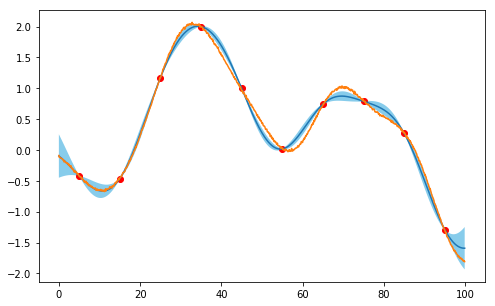

In [15]:
plt.figure(1,figsize=(8,5))
axs=plt.subplot(111)
axs.plot(xi,u,'ro')
axs.plot(f[0],f[1])
axs.fill_between(f[0],f[1]-np.sqrt(np.diagonal(f[2])),f[1]+np.sqrt(np.diagonal(f[2])),facecolor=(0.53,0.8,0.92))
axs.plot(f[0],f_1)
plt.show()

In [16]:
lamda=f_1**2

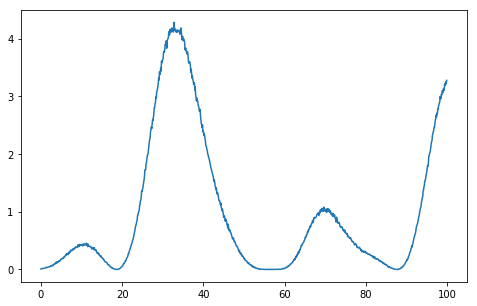

In [17]:
plt.figure(1,figsize=(8,5))
axs=plt.subplot(111)
axs.plot(f[0],lamda)
plt.show()

In [18]:
def inhomo_simulation(measure,delta_t,measure_sup,T):
    t=0
    points_homo=[]
    points_inhomo=[]
    while(t<T):
        points_homo.append(t)
        r=expon.rvs(scale=1/measure_sup) #scale=1/lamda
        t+=r
        if t>=T: break
        D=uniform.rvs(loc=0,scale=1)
        if D*measure_sup<=measure[int(t/delta_t)]:
            points_inhomo.append(t)
    if points_inhomo[-1]>T:
        del points_inhomo[-1]
    del points_homo[0]
    return points_inhomo

## simulation for gaussian process poisson process

In [19]:
points_inhomo=inhomo_simulation(lamda,0.1,max(lamda),T)

In [20]:
len(points_inhomo)

83

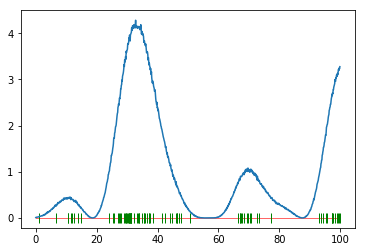

In [21]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot([0,T],[0,0],'r-',lw=1,alpha=0.6)
plt.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10)
plt.plot(f[0],lamda)
plt.show()

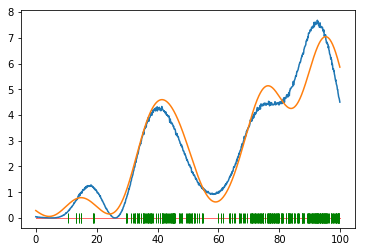

In [742]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot([0,T],[0,0],'r-',lw=1,alpha=0.6)
plt.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10)
plt.plot(f[0],lamda)
plt.plot(f[0],lamda_predict)
plt.show()

## varitional inference

In [632]:
def KL_gaussian(mean_q,cov_q,mean_p,cov_p): # verified
    assert len(mean_p)==len(mean_q)
    cov_p_inv=np.linalg.inv(cov_p)
    return (np.trace(np.matmul(cov_p_inv,cov_q))+np.log(np.linalg.det(cov_p))-np.log(np.linalg.det(cov_q))-len(mean_p)\
    +np.matmul(np.matmul((mean_p-mean_q),cov_p_inv),(mean_p-mean_q).T))/2

In [633]:
def psi(theta0,theta1,xn,xm,T):
    x_mean=(xn+xm)/2
    return (theta0**2)*(-np.sqrt(np.pi/theta1)/2)*np.exp((-theta1*(xn-xm)**2)/4)*(erf((x_mean-T)*np.sqrt(theta1))\
                                                                                  -erf(x_mean*np.sqrt(theta1)))

In [634]:
def G_fun(z):
    return (hyp1f1(0.001,0.5,z)-hyp1f1(0,0.5,z))/0.001

In [635]:
xxxx=np.linspace(-5000,0,500000)
G_value=[]
for i in range(len(xxxx)):
    G_value.append(G_fun(xxxx[i]))

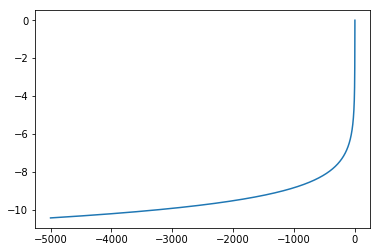

In [636]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot(xxxx,G_value)
plt.show()

In [681]:
def G(z):
    assert z<=0, print(z)
    assert z>=-5000, print(z)
    index=int((5000+z)/0.01)
    if index==500000:
        return 0
    else:
        return G_value[index]

In [682]:
def ELBO(theta0,theta1,xi,mean_p_u,cov_p_u,mean_q_u,cov_q_u,T, points_inhomo): # xi is inducing points
    assert len(mean_p_u)==len(mean_q_u)==len(xi)
    N=len(xi) # N is number of inducing points
#     M=len(x_predict)
    Psi=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            Psi[i][j]=psi(theta0,theta1,xi[i],xi[j],T)
            Psi[j][i]=Psi[i][j]
    
    fourth_term=-KL_gaussian(mean_q_u,cov_q_u,mean_p_u,cov_p_u)
    
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    
    first_term=-np.matmul(np.matmul(np.matmul(np.matmul(mean_q_u,cov_p_u_inv),Psi),cov_p_u_inv),mean_q_u.T)
    
    second_term=-(theta0*T-np.trace(np.matmul(cov_p_u_inv,Psi))+np.trace(np.matmul(np.matmul(np.matmul(cov_p_u_inv,cov_q_u),cov_p_u_inv),Psi)))
    
    
#     K_xz=np.zeros((M,N))
#     for i in range(M):
#         for j in range(N):
#             K_xz[i][j]=expo_quad_kernel(theta0,theta1,x_predict[i],xi[j])
#     K_xx=np.zeros((M,M))
#     for i in range(M):
#         for j in range(i,M):
#             K_xx[i][j]=expo_quad_kernel(theta0,theta1,x_predict[i],x_predict[j])
#             K_xx[j][i]=K_xx[i][j]
#     mean_predict=(K_xz.dot(cov_p_u_inv)).dot(mean_q_u)
#     cov_predict=K_xx-(K_xz.dot(cov_p_u_inv)).dot(K_xz.T)+(((K_xz.dot(cov_p_u_inv)).dot(cov_q_u)).dot(cov_p_u_inv)).dot(K_xz.T)
    
    third_term=0
    for i in range(len(points_inhomo)):
        k_vec=np.array([])
        for j in range(N):
            k_vec=np.append(k_vec,expo_quad_kernel(theta0,theta1,points_inhomo[i],xi[j]))
        mean=np.matmul(np.matmul(k_vec,cov_p_u_inv),mean_q_u)
        var=theta0-np.matmul(np.matmul(k_vec,cov_p_u_inv),k_vec.T)+np.matmul(np.matmul(np.matmul(np.matmul(k_vec,cov_p_u_inv),cov_q_u),cov_p_u_inv),k_vec.T)
        assert var>0, print(var)
        third_term+=-G(-(mean**2)/2/var)+np.log(var/2)-0.57721566
#     third_ttt=0
#     for i in range(len(points_inhomo)):
#         k_xz=np.array([expo_quad_kernel(theta0,theta1,points_inhomo[i],xi[j]) for j in range(N)])
#         mean=(k_xz.dot(cov_p_u_inv)).dot(mean_q_u)
#         var=theta0-(k_xz.dot(cov_p_u_inv)).dot(k_xz.T)+(((k_xz.dot(cov_p_u_inv)).dot(cov_q_u)).dot(cov_p_u_inv)).dot(k_xz.T)
#         mean_list2.append(mean)
#         var_list2.append(var)
#         fn=norm(mean,np.sqrt(var)).rvs(size=2000)
#         third_ttt+=sum(np.log(fn**2))/2000
    return first_term+second_term+third_term+fourth_term

In [683]:
ELBO(theta0,theta1,xi,mean_p_u,cov_p_u,np.ones(10),np.eye(10),T,points_inhomo)

-332.43703643649724

In [684]:
ELBO(theta0,theta1,xi,mean_p_u,cov_p_u,np.zeros(10),np.eye(10),T,points_inhomo)

-476.16243883739008

In [714]:
def loss(parameter_list,theta0,theta1,xi,mean_p_u,cov_p_u,T,points_inhomo):
    N=len(xi)
    mean_q_u=np.array(parameter_list[:N])
#     assert len(parameter_list)==2*N  # diagonal cov_q
#     cov_q_u=np.diag(parameter_list[N:])
    assert len(parameter_list)==N*(N+3)/2  # lower triangular cov_q
    L = np.zeros((N, N))
    L[np.tril_indices(N, 0)] = parameter_list[N:]
    cov_q_u=L.dot(L.T)
    return -ELBO(theta0,theta1,xi,mean_p_u,cov_p_u,mean_q_u,cov_q_u,T,points_inhomo)

In [733]:
loss([1]*65,theta0,theta1,xi,mean_p_u,cov_p_u,T,points_inhomo)

434.20013808912194

In [734]:
init=np.random.uniform(0,2,65)
res=optimize.minimize(loss, init, args=(theta0,theta1,xi,mean_p_u,cov_p_u,T,points_inhomo), method='SLSQP', tol=1e-6, \
        bounds=[(0,2)]*10+[(0.01,10)]*55, options={'disp': True, 'maxiter':500 })

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 248.3293276672723
            Iterations: 76
            Function evaluations: 5144
            Gradient evaluations: 76


In [735]:
res.x

array([  3.34809704e-06,   1.06926898e-16,   9.08293513e-06,
         1.41491632e-05,   5.08219815e-06,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         7.38612730e-19,   2.52257952e-01,   4.13544289e-01,
         7.84774234e-01,   5.31151702e-02,   1.52811606e-01,
         3.76843515e-01,   1.00000000e-02,   1.00000000e-02,
         1.32816197e+00,   1.20474728e+00,   1.53984054e-01,
         4.36824064e-01,   1.09156315e+00,   1.37336626e+00,
         9.65901706e-01,   7.74555457e-02,   2.27838094e-01,
         3.57551730e-01,   5.11134121e-01,   6.96350452e-01,
         4.53797428e-01,   1.00000000e-02,   1.00000000e-02,
         1.00000000e-02,   1.00000000e-02,   1.00000000e-02,
         5.42712365e-01,   1.15583911e+00,   3.05122181e-02,
         5.40643428e-02,   8.87433378e-02,   1.17879598e-01,
         1.63144522e-01,   4.34158568e-01,   1.93665824e+00,
         1.03439771e+00,   2.26597950e-02,   3.92238057e-02,
         6.33313407e-02,

In [737]:
mean_q_u_post=res.x[:10]

In [738]:
L = np.zeros((10, 10))
L[np.tril_indices(10, 0)] = res.x[10:]

In [739]:
cov_q_u_post=L.dot(L.T)

In [740]:
def distribution_f_posterior(x_f,xi,theta0,theta1,cov_p_u,mean_q_u_post,cov_q_u_post):
    N=len(xi) # N is number of inducing points
    M=len(x_f) # M is number of predicting points
    
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    
    K_xz=np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            K_xz[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],xi[j])
    K_xx=np.zeros((M,M))
    for i in range(M):
        for j in range(i,M):
            K_xx[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],x_f[j])
            K_xx[j][i]=K_xx[i][j]
    mean_f=(K_xz.dot(cov_p_u_inv)).dot(mean_q_u_post)
    cov_f=K_xx-(K_xz.dot(cov_p_u_inv)).dot(K_xz.T)+(((K_xz.dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz.T)
    
    exp_lamda=mean_f**2+np.diagonal(cov_f)
    return mean_f,cov_f, exp_lamda

In [741]:
_,_,lamda_predict=distribution_f_posterior(f[0],xi,theta0,theta1,cov_p_u,mean_q_u_post,cov_q_u_post)